In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import h5py
import os.path

import image_proc
import train_detector

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from craft.craft import CRAFT

import time

In [65]:
class SynthCharMapDataset(Dataset):
    """SynthText Dataset + Heatmap + Direction Ground Truths"""

    def __init__(self, gt_path, img_dir, color_flag=1, hard_examples=False, #transform=None,
                 character_map=True, affinity_map=True, direction_map=True, word_map=True,
                 begin=0, cuda=True):
        """
        Args:
            gt_path (string): Path to gt.mat file (GT file)
            img_dir (string): Path to directory of {i}/....jpg (folders of images)

            color_flag {1,0,-1}: Colored (1), Grayscale (0), or Unchanged (-1)
        """
        super(SynthCharMapDataset).__init__()

        # paths
        self.gt_path = gt_path
        self.img_dir = img_dir
        
        # flags
        self.color_flag = color_flag
        self.hard_examples = hard_examples
        self.character_map = character_map
        self.affinity_map = affinity_map
        self.word_map = word_map
        self.direction_map = direction_map
        
        # templates
        if self.character_map:
            self.gaussian_template = image_proc.genGaussianTemplate()
        if self.direction_map:
            self.direction_template = image_proc.genDirectionMapTemplate()

        self.f = h5py.File(gt_path, 'r')
        self.length = len(self.f['imnames'])
        
        self.begin = 0
        if begin > 0:
            self.begin = begin
            self.length -= begin
        
        if cuda:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # if changing starting index
        idx += self.begin

        f = self.f
        imgname = image_proc.u2ToStr(f[f['imnames'][idx][0]])
        charBBs = f[f['charBB'][idx][0]].value
        wordBBs = f[f['wordBB'][idx][0]].value
        txts    = f[f['txt'][idx][0]]

        imgpath = os.path.join(self.img_dir, imgname)
        synthetic_image = cv2.imread(imgpath, self.color_flag).transpose(2,0,1)# HWC to CHW
        image_shape = synthetic_image.shape[-2:]

        char_map, aff_map = image_proc.genPseudoGT(charBBs, txts, image_shape,
                            generate_affinity=self.affinity_map, template=self.gaussian_template)
        if self.word_map:
            word_map = image_proc.genWordGT(wordBBs, image_shape, template=self.gaussian_template)
        if self.direction_map:
            cos_map, sin_map  = image_proc.genDirectionGT(charBBs, image_shape, normalize=False,
                                                            template=self.direction_template)

        # combine gts to a single tensor
        gt = None
        if self.character_map:
            gt = char_map[None,...]
        if self.affinity_map:
            affinity_map = aff_map[None,...]
            if gt is None:
                gt = affinity_map
            else:
                gt = np.concatenate((gt, affinity_map))
        if self.word_map:
            word_map = word_map[None,...]
            if gt is None:
                gt = word_map
            else:
                gt = np.concatenate((gt, word_map))
        if self.direction_map:
            dir_map = np.concatenate((cos_map[None,...], sin_map[None,...]))
            if gt is None:
                gt = dir_map
            else:
                gt = np.concatenate((gt, dir_map))

        # get hard examples + corresponding gts
        if self.hard_examples:
            hard_img, hard_gt = image_proc.hard_example_mining(synthetic_image, gt, wordBBs)
            # hard_img: NCHW
            # hard_gt: NCHW -> NHWC
            
            hard_gt = torch.from_numpy(hard_gt).type(self.dtype)
            hard_gt_resized = F.interpolate(hard_gt, scale_factor=0.5).permute(0,2,3,1)
            
            hard_img = torch.from_numpy(hard_img).type(self.dtype) / 255.0

        # resize to match feature map size
        # to match expectations of F.interpolate, we reshape to NCHW
        gt = torch.from_numpy(gt[None,...]).type(self.dtype)
        gt_resized = F.interpolate(gt, scale_factor=0.5)[0].permute(1,2,0)# HWC
        
        #synthetic_image = self.transform(synthetic_image)
        synthetic_image = torch.from_numpy(synthetic_image).type(self.dtype)# CHW
        synthetic_image = synthetic_image / 255.0

        if self.hard_examples:
#             print(f"hard_gt_resized.shape = {hard_gt_resized.shape}")
            return synthetic_image, gt_resized, hard_img, hard_gt_resized
        else:
            return synthetic_image, gt_resized

In [2]:
from importlib import reload
from train_detector import SynthCharMapDataset

In [20]:
reload(train_detector)
from train_detector import SynthCharMapDataset

In [21]:
gt_path = "/home/eee198/Downloads/SynthText/gt_v7.3.mat"#"/media/aerjay/Acer/Users/Aerjay/Downloads/SynthText/gt_v7.3.mat"
img_dir = "/home/eee198/Downloads/SynthText/images"#"/media/aerjay/Acer/Users/Aerjay/Downloads/SynthText/SynthText"

begin = 0

# remember requires_grad=True
dataset = SynthCharMapDataset(gt_path, img_dir, affinity_map=False, direction_map=True, word_map=False,
                              begin=begin, cuda=True, hard_examples=False)
train, test = torch.utils.data.random_split(dataset, [800000,58750])
dataloader = DataLoader(train, batch_size=4, shuffle=True, collate_fn=image_proc.collate)

In [ ]:
for img,gt,hard_img,hard_gt in dataloader:
    print(f"img.shape = {img.shape}")
    print(f"gt.shape = {gt.shape}")
    print(f"hard_img.shape = {hard_img.shape}")
    print(f"hard_gt.shape = {hard_gt.shape}")
    break

dir_maps = gt[0].permute(2,0,1)
print(dir_maps.shape)
print(torch.max(dir_maps[1]))
print(torch.min(dir_maps[1]))

In [88]:
print(torch.min(gt[:,:,:,-2:]))
print(torch.max(gt[:,:,:,-2:]))
a = (torch.clamp(gt[:,:,:,-2:],-1,1) + 1)/2
print(f"a.shape = {a.shape}")
print(torch.min(a[0].permute(2,0,1)[1]))
print(torch.max(a[0].permute(2,0,1)[1]))
print(torch.max(a[:,:,:,-2:]))
print(torch.min(a[:,:,:,-2:]))
b = ((a[:,:,:,-2:])*2) - 1
print(b.shape)
print(torch.max(b[:,:,:,-2:]))
print(torch.min(b[:,:,:,-2:]))
print(torch.min(b[0].permute(2,0,1)[1]))
print(torch.max(b[0].permute(2,0,1)[1]))

tensor(-1.5475, device='cuda:0')
tensor(1.4698, device='cuda:0')
a.shape = torch.Size([4, 300, 300, 2])
tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
torch.Size([4, 300, 300, 2])
tensor(1., device='cuda:0')
tensor(-1., device='cuda:0')
tensor(-1., device='cuda:0')
tensor(1., device='cuda:0')


In [50]:
for sample in dataloader:
    break

# overfitting function
def same_inputs(sample):
    while(True):
        yield sample

In [5]:
# folder_name = "[3-09-20]_gauss_template"
print(f"folder_name: {folder_name}")

T_save = 10000
T = 100
epochs = 1
start = time.time()

for epoch in range(epochs):
    running_loss = 0.0

    while(True):
        try:
            for i, (img, target, hard_img, hard_target) in enumerate(dataloader):
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output, _ = model(img.cuda())
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % T == T-1:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss/T))
                    running_loss = 0.0

                ## Hard Example Training
                #for hard_img, hard_target in zip(hard_imgs, hard_targets):
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output, _ = model(hard_img)
                output[:,:,:,-2:] = (np.clip(output[:,:,:,-2:],-1,1) + 1)/2
                loss = criterion(output, hard_target)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % T == T-1:    # print every 2000 mini-batches
                    print('\t[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss/T))
                    running_loss = 0.0



                if i % T_save == T_save-1:
                    print(f"\nsaving at {i}-th batch'\n")
                    torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/{folder_name}/w_{i}.pth")
                    end = time.time()
                    print(f"\nElapsed time: {end-start}")
            break
        except MemoryError:
            print("Memory Error")
            continue
        except AttributeError:
            print("Attribute Error")
        except KeyboardInterrupt:
            print(f"\nsaving at {i}-th batch'\n")
            torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/{folder_name}/w_{i}_interrupt.pth")
            end = time.time()
            print(f"\nElapsed time: {end-start}")
            
            break
        except:
            continue


print("Finished training.")

end = time.time()
print(f"\nTotal elapsed time: {end-start}")

folder_name: [3-10-20]_no_word_map
[1,   100] loss: 0.263480
	[1,   100] loss: 0.001594
[1,   200] loss: 0.228303
	[1,   200] loss: 0.001247
[1,   300] loss: 0.193457
	[1,   300] loss: 0.001134
[1,   400] loss: 0.165105
	[1,   400] loss: 0.000803
[1,   500] loss: 0.141663
	[1,   500] loss: 0.000678
[1,   600] loss: 0.128284
	[1,   600] loss: 0.000591
[1,   700] loss: 0.118526
	[1,   700] loss: 0.000632
[1,   800] loss: 0.112483
	[1,   800] loss: 0.000571
[1,   900] loss: 0.108455
	[1,   900] loss: 0.000513
[1,  1000] loss: 0.103761
	[1,  1000] loss: 0.000526
[1,  1100] loss: 0.099573
	[1,  1100] loss: 0.000518
[1,  1200] loss: 0.097618
	[1,  1200] loss: 0.000514
[1,  1300] loss: 0.093999
	[1,  1300] loss: 0.000433
[1,  1400] loss: 0.089865
	[1,  1400] loss: 0.000423
[1,  1500] loss: 0.087997
	[1,  1500] loss: 0.000483
[1,  1600] loss: 0.086850
	[1,  1600] loss: 0.000447
[1,  1700] loss: 0.084325
	[1,  1700] loss: 0.000444
[1,  1800] loss: 0.082715
	[1,  1800] loss: 0.000401
[1,  1900] 

	[1,  5400] loss: 0.000088
[1,  5500] loss: 0.022684
	[1,  5500] loss: 0.000196
[1,  5600] loss: 0.023783
	[1,  5600] loss: 0.000164
[1,  5700] loss: 0.026673
	[1,  5700] loss: 0.000230
[1,  5800] loss: 0.024782
	[1,  5800] loss: 0.000260
[1,  5900] loss: 0.023551
	[1,  5900] loss: 0.000093
[1,  6000] loss: 0.024700
	[1,  6000] loss: 0.000073
[1,  6100] loss: 0.024341
	[1,  6100] loss: 0.000103
[1,  6200] loss: 0.024351
	[1,  6200] loss: 0.000120
[1,  6300] loss: 0.023521
	[1,  6300] loss: 0.000098
[1,  6400] loss: 0.021990
	[1,  6400] loss: 0.000141
[1,  6500] loss: 0.023810
	[1,  6500] loss: 0.000134
[1,  6600] loss: 0.022881
	[1,  6600] loss: 0.000092
[1,  6700] loss: 0.022913
	[1,  6700] loss: 0.000181
[1,  6800] loss: 0.024273
	[1,  6800] loss: 0.000106
[1,  6900] loss: 0.024342
	[1,  6900] loss: 0.000116
[1,  7000] loss: 0.023853
	[1,  7000] loss: 0.000079
[1,  7100] loss: 0.023950
	[1,  7100] loss: 0.000140
[1,  7200] loss: 0.023192
	[1,  7200] loss: 0.000125
[1,  7300] loss: 0.

	[1,   800] loss: 0.000111
[1,   900] loss: 0.020433
	[1,   900] loss: 0.000200
[1,  1000] loss: 0.018644
	[1,  1000] loss: 0.000085
[1,  1100] loss: 0.022906
	[1,  1100] loss: 0.000146
[1,  1200] loss: 0.026926
	[1,  1200] loss: 0.000116
[1,  1300] loss: 0.020745
	[1,  1300] loss: 0.000108
[1,  1400] loss: 0.019391
	[1,  1400] loss: 0.000072
[1,  1500] loss: 0.026831
	[1,  1500] loss: 0.000233
[1,  1600] loss: 0.020595
	[1,  1600] loss: 0.000178
[1,  1700] loss: 0.021713
	[1,  1700] loss: 0.000153
[1,  1800] loss: 0.020781
	[1,  1800] loss: 0.000103
[1,  1900] loss: 0.020256
	[1,  1900] loss: 0.000167
[1,  2000] loss: 0.019839
	[1,  2000] loss: 0.000111
[1,  2100] loss: 0.020906
	[1,  2100] loss: 0.000112
[1,  2200] loss: 0.029840
	[1,  2200] loss: 0.000077
[1,  2300] loss: 0.021171
	[1,  2300] loss: 0.000123
[1,  2400] loss: 0.022900
	[1,  2400] loss: 0.000116
[1,  2500] loss: 0.021136
	[1,  2500] loss: 0.000083
[1,  2600] loss: 0.018463
	[1,  2600] loss: 0.000072
[1,  2700] loss: 0.

[1,  6300] loss: 0.020124
	[1,  6300] loss: 0.000068
[1,  6400] loss: 0.019815
	[1,  6400] loss: 0.000077
[1,  6500] loss: 0.019251
	[1,  6500] loss: 0.000069
[1,  6600] loss: 0.018240
	[1,  6600] loss: 0.000112
[1,  6700] loss: 0.018618
	[1,  6700] loss: 0.000124
[1,  6800] loss: 0.018567
	[1,  6800] loss: 0.000147
[1,  6900] loss: 0.018504
	[1,  6900] loss: 0.000067
[1,  7000] loss: 0.019902
	[1,  7000] loss: 0.000164
[1,  7100] loss: 0.019133
	[1,  7100] loss: 0.000120
[1,  7200] loss: 0.019436
	[1,  7200] loss: 0.000069
[1,  7300] loss: 0.019826
	[1,  7300] loss: 0.000099
[1,  7400] loss: 0.018544
	[1,  7400] loss: 0.000123
[1,  7500] loss: 0.019716
	[1,  7500] loss: 0.000116
[1,  7600] loss: 0.018773
	[1,  7600] loss: 0.000068
[1,  7700] loss: 0.019292
	[1,  7700] loss: 0.000167
[1,  7800] loss: 0.019114
	[1,  7800] loss: 0.000162
[1,  7900] loss: 0.020183
	[1,  7900] loss: 0.000101
[1,  8000] loss: 0.019333
	[1,  8000] loss: 0.000103
[1,  8100] loss: 0.018725
	[1,  8100] loss: 0.

[1,  1700] loss: 0.018191
	[1,  1700] loss: 0.000078
[1,  1800] loss: 0.017840
	[1,  1800] loss: 0.000059
[1,  1900] loss: 0.018856
	[1,  1900] loss: 0.000050
[1,  2000] loss: 0.018780
	[1,  2000] loss: 0.000170
[1,  2100] loss: 0.018994
	[1,  2100] loss: 0.000152
[1,  2200] loss: 0.018871
	[1,  2200] loss: 0.000129
[1,  2300] loss: 0.018026
	[1,  2300] loss: 0.000147
[1,  2400] loss: 0.018674
	[1,  2400] loss: 0.000127
[1,  2500] loss: 0.018151
	[1,  2500] loss: 0.000114
[1,  2600] loss: 0.017238
	[1,  2600] loss: 0.000123
[1,  2700] loss: 0.019235
	[1,  2700] loss: 0.000151
[1,  2800] loss: 0.017754
	[1,  2800] loss: 0.000052
[1,  2900] loss: 0.018512
	[1,  2900] loss: 0.000073
[1,  3000] loss: 0.018747
	[1,  3000] loss: 0.000111
[1,  3100] loss: 0.017663
	[1,  3100] loss: 0.000134
[1,  3200] loss: 0.017007
	[1,  3200] loss: 0.000107
[1,  3300] loss: 0.017734
	[1,  3300] loss: 0.000113
[1,  3400] loss: 0.019058
	[1,  3400] loss: 0.000067
[1,  3500] loss: 0.018104
	[1,  3500] loss: 0.

	[1,  7100] loss: 0.000113
[1,  7200] loss: 0.016906
	[1,  7200] loss: 0.000203
[1,  7300] loss: 0.018389
	[1,  7300] loss: 0.000108
[1,  7400] loss: 0.018192
	[1,  7400] loss: 0.000167
[1,  7500] loss: 0.017228
	[1,  7500] loss: 0.000077
[1,  7600] loss: 0.017550
	[1,  7600] loss: 0.000108
[1,  7700] loss: 0.016125
	[1,  7700] loss: 0.000183
[1,  7800] loss: 0.018012
	[1,  7800] loss: 0.000115
[1,  7900] loss: 0.018291
	[1,  7900] loss: 0.000116
[1,  8000] loss: 0.031062
	[1,  8000] loss: 0.000103
[1,  8100] loss: 0.017823
	[1,  8100] loss: 0.000111
[1,  8200] loss: 0.019023
	[1,  8200] loss: 0.000100
[1,  8300] loss: 0.017915
	[1,  8300] loss: 0.000101
[1,  8400] loss: 0.018176
	[1,  8400] loss: 0.000169
[1,  8500] loss: 0.018451
	[1,  8500] loss: 0.000322
[1,  8600] loss: 0.018041
	[1,  8600] loss: 0.000214
[1,  8700] loss: 0.017861
	[1,  8700] loss: 0.000106
[1,  8800] loss: 0.016470
	[1,  8800] loss: 0.000141
[1,  8900] loss: 0.018518
	[1,  8900] loss: 0.000114
[1,  9000] loss: 0.

	[1,  2500] loss: 0.000062
[1,  2600] loss: 0.015916
	[1,  2600] loss: 0.000260
[1,  2700] loss: 0.018211
	[1,  2700] loss: 0.000075
[1,  2800] loss: 0.016894
	[1,  2800] loss: 0.000055
[1,  2900] loss: 0.018557
	[1,  2900] loss: 0.000076
[1,  3000] loss: 0.018003
	[1,  3000] loss: 0.000099
[1,  3100] loss: 0.017514
	[1,  3100] loss: 0.000075
[1,  3200] loss: 0.017623
	[1,  3200] loss: 0.000106
[1,  3300] loss: 0.017878
	[1,  3300] loss: 0.000150
[1,  3400] loss: 0.016245
	[1,  3400] loss: 0.000119
[1,  3500] loss: 0.017882
	[1,  3500] loss: 0.000066
[1,  3600] loss: 0.017756
	[1,  3600] loss: 0.000054
[1,  3700] loss: 0.016644
	[1,  3700] loss: 0.000094
[1,  3800] loss: 0.017325
	[1,  3800] loss: 0.000075
[1,  3900] loss: 0.017412
	[1,  3900] loss: 0.000098
[1,  4000] loss: 0.017132
	[1,  4000] loss: 0.000128
[1,  4100] loss: 0.023770
	[1,  4100] loss: 0.000064
[1,  4200] loss: 0.017374
	[1,  4200] loss: 0.000135
[1,  4300] loss: 0.017279
	[1,  4300] loss: 0.000101
[1,  4400] loss: 0.

	[1,   800] loss: 0.000100
[1,   900] loss: 0.015440
	[1,   900] loss: 0.000051
[1,  1000] loss: 0.016509
	[1,  1000] loss: 0.000116
[1,  1100] loss: 0.017894
	[1,  1100] loss: 0.000072
[1,  1200] loss: 0.018432
	[1,  1200] loss: 0.000088
[1,  1300] loss: 0.016162
	[1,  1300] loss: 0.000059
[1,  1400] loss: 0.018871
	[1,  1400] loss: 0.000070
[1,  1500] loss: 0.015871
	[1,  1500] loss: 0.000050
[1,  1600] loss: 0.015812
	[1,  1600] loss: 0.000123
[1,  1700] loss: 0.020563
	[1,  1700] loss: 0.000199
[1,  1800] loss: 0.016825
	[1,  1800] loss: 0.000105
[1,  1900] loss: 0.016187
	[1,  1900] loss: 0.000055
[1,  2000] loss: 0.019143
	[1,  2000] loss: 0.000063
[1,  2100] loss: 0.016030
	[1,  2100] loss: 0.000042
[1,  2200] loss: 0.017222
	[1,  2200] loss: 0.000163
[1,  2300] loss: 0.016676
	[1,  2300] loss: 0.000049
[1,  2400] loss: 0.016015
	[1,  2400] loss: 0.000054
[1,  2500] loss: 0.017460
	[1,  2500] loss: 0.000051
[1,  2600] loss: 0.016594
	[1,  2600] loss: 0.000095
[1,  2700] loss: 0.

[1,  6300] loss: 0.022015
	[1,  6300] loss: 0.000053
[1,  6400] loss: 0.017029
	[1,  6400] loss: 0.000061
[1,  6500] loss: 0.016871
	[1,  6500] loss: 0.000110
[1,  6600] loss: 0.017511
	[1,  6600] loss: 0.000112
[1,  6700] loss: 0.018046
	[1,  6700] loss: 0.000100
[1,  6800] loss: 0.017845
	[1,  6800] loss: 0.000115
[1,  6900] loss: 0.015943
	[1,  6900] loss: 0.000036
[1,  7000] loss: 0.017228
	[1,  7000] loss: 0.000056
[1,  7100] loss: 0.016162
	[1,  7100] loss: 0.000081
[1,  7200] loss: 0.019044
	[1,  7200] loss: 0.000120
[1,  7300] loss: 0.016200
	[1,  7300] loss: 0.000087
[1,  7400] loss: 0.019640
	[1,  7400] loss: 0.000116
[1,  7500] loss: 0.017672
	[1,  7500] loss: 0.000085
[1,  7600] loss: 0.017483
	[1,  7600] loss: 0.000067

saving at 7658-th batch'



FileNotFoundError: [Errno 2] No such file or directory: '/home/eee198/Downloads/SynthText/weights/[3-10-20]_no_word_map/w_7658_interrupt.pth'

In [6]:
torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/{folder_name}/w_{i}_interrupt.pth")

In [7]:
model.load_state_dict(torch.load(pth_path))
model.eval()

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, 

In [46]:
for img, gt, hard_img, hard_gt in dataloader:
    print(f"img.shape = {img.shape}")
    print(f"img.shape = {gt.shape}")
    print(f"img.shape = {hard_img.shape}")
    print(f"img.shape = {hard_gt.shape}")
    break

img.shape = torch.Size([4, 3, 400, 600])
img.shape = torch.Size([4, 200, 300, 3])
img.shape = torch.Size([16, 3, 169, 180])
img.shape = torch.Size([16, 84, 90, 3])


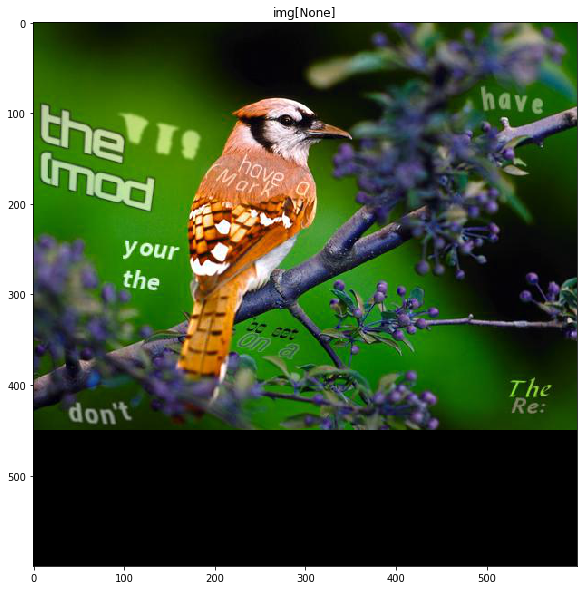

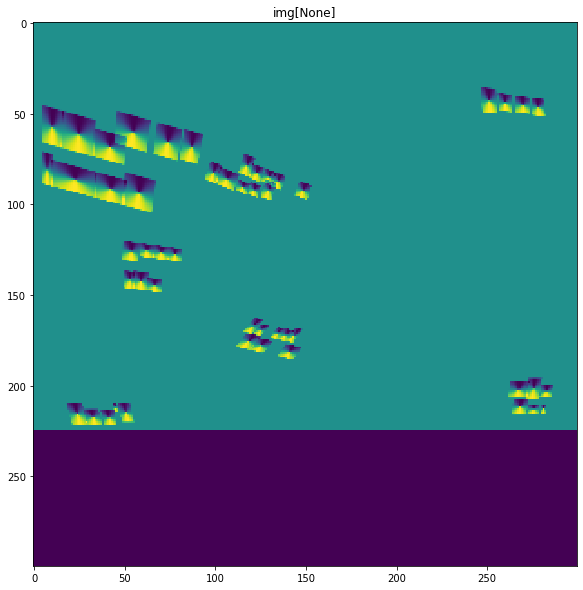

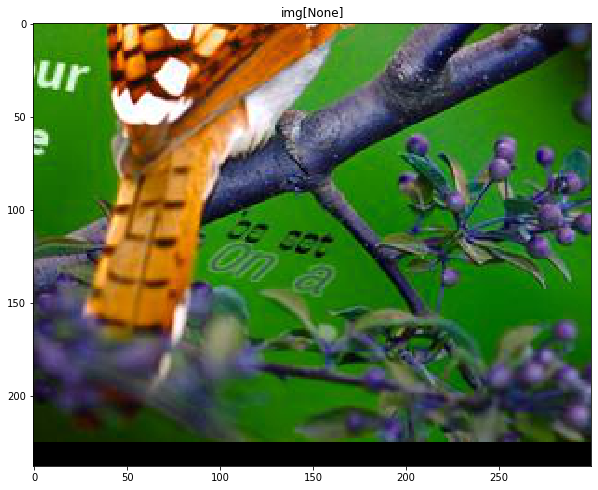

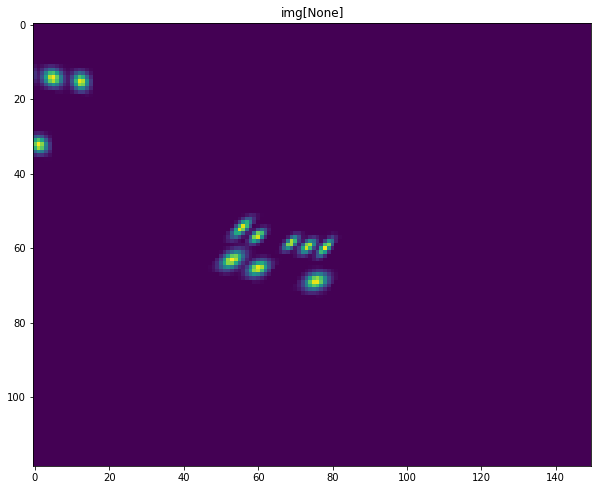

In [57]:
def show_samples(imgs, i=None, feature_type="img", title=None, channel=None):
    imgs = imgs.detach().cpu().numpy()
    if i == None:
        img = imgs
    else:
        img = imgs[i]

    if feature_type == "img":
        img = img.transpose(1,2,0)
    elif feature_type == "gt":
        pass

    if channel != None:
        img = img[:,:,channel]
        
    if title is None:
        title = f"img[{i}]"

    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(img, interpolation='nearest')

    plt.show()

i = 0
show_samples(img[i])
show_samples(gt[i], feature_type="gt", channel=2)
show_samples(hard_img[i])
show_samples(hard_gt[i], feature_type="gt", channel=0)

In [9]:
output, _ = model(img.cuda())
print(f"output.shape = {output.shape}")

output.shape = torch.Size([4, 300, 300, 3])


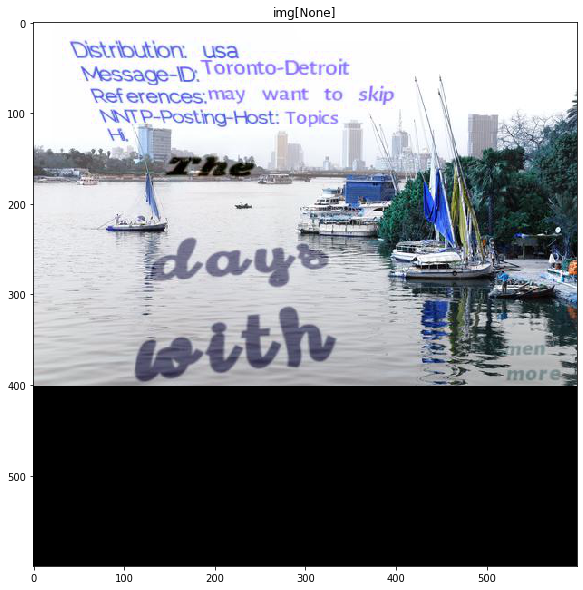

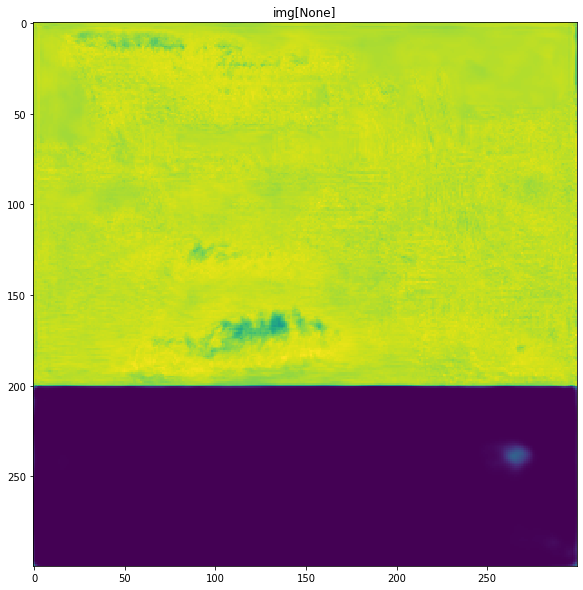

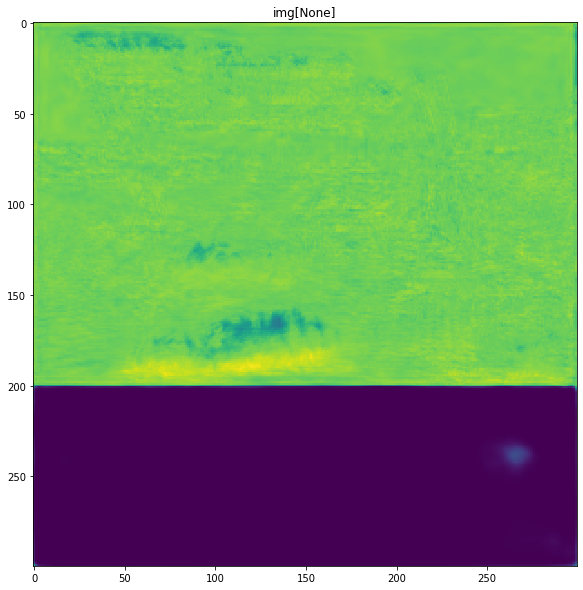

In [51]:
i = 0
show_samples(img[i])
show_samples(output[i], feature_type="gt", channel=1)
show_samples(output[i], feature_type="gt", channel=2)